<a href="https://colab.research.google.com/github/chiragvaswani/KeyframeExtraction/blob/main/KeyframeExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [3]:
cap = cv2.VideoCapture('Video.mp4') 

arr = np.empty((0, 1944), int)   #initializing 1944 dimensional array to store 'flattened' color histograms
D=dict()   #to store the original frame (array)
count=0    #counting the number of frames
start_time = time.time()
while cap.isOpened():
    
    # Read the video file.
    ret, frame = cap.read()
    
    # If we got frames.
    if ret == True:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  #since cv reads frame in bgr order so rearraning to get frames in rgb order
        D[count] = frame_rgb   #storing each frame (array) to D , so that we can identify key frames later 
        
        #dividing a frame into 3*3 i.e 9 blocks
        height, width, channels = frame_rgb.shape

        if height % 3 == 0:
            h_chunk = int(height/3)
        else:
            h_chunk = int(height/3) + 1

        if width % 3 == 0:
            w_chunk = int(width/3)
        else:
            w_chunk = int(width/3) + 1

        h=0
        w= 0 
        feature_vector = []
        for a in range(1,4):
            h_window = h_chunk*a
            for b in range(1,4):
                frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])#finding histograms for each block  
                hist1= hist.flatten()  #flatten the hist to one-dimensinal vector 
                feature_vector += list(hist1)
                w = w_chunk*b
                
            h = h_chunk*a
            w= 0

                
        arr =np.vstack((arr, feature_vector )) #appending each one-dimensinal vector to generate N*M matrix (where N is number of frames
          #and M is 1944) 
        count+=1
    else:
        break

print("--- %s seconds ---" % (time.time() - start_time))

final_arr = arr.transpose() #transposing so that i will have all frames in columns i.e M*N dimensional matrix 
#where M is 1944 and N is number of frames
print(final_arr.shape)
print(count)

--- 20.751948833465576 seconds ---
(1944, 1832)
1832


In [5]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
A = csc_matrix(final_arr, dtype=float) # csc matrices falicilate fast operations
print(A.shape)
#top 63 singular values from 76082 to 508
u, s, vt = svds(A, k = 63) # single value decomposition

(1944, 1832)


In [6]:
print(u.shape, s.shape, vt.shape)

(1944, 63) (63,) (63, 1832)


In [7]:
print(list(s))

[507.5863397910356, 513.3394019469025, 542.5885461980122, 557.4615730264477, 581.1252578281178, 595.6523491133403, 625.86762511288, 667.354303844587, 703.9369306867553, 785.0033226440925, 824.1240297172757, 830.2095332996922, 862.3243911201415, 962.1678005881328, 993.1884335353175, 1074.4879221595836, 1104.0363306894765, 1174.379587119881, 1310.4024628743837, 1429.8059729265544, 1436.0497628725561, 1784.0835463882945, 1920.574374704026, 2075.512482267338, 2235.993003895146, 2450.850435862492, 2789.861284247543, 3266.4378720353498, 3467.45433269782, 3703.2744228804363, 4026.5120288278313, 4160.600410916421, 4339.99256470421, 4608.340768433541, 4872.71177292728, 5124.862670258989, 5276.30954252311, 5668.146768603113, 5931.507922089643, 5952.291087578099, 6235.342567902841, 6697.2983210833945, 6776.947714481716, 7065.201258998798, 7853.121480587884, 8067.823543248015, 8691.548708604727, 9140.661744359924, 9938.174572146707, 10316.757223295492, 10792.03020156712, 11187.86326121343, 11687.0

In [8]:
v1_t = vt.transpose()

projections = v1_t @ np.diag(s) #the column vectors i.e the frame histogram data has been projected onto the orthonormal basis 
#formed by vectors of the left singular matrix u .The coordinates of the frames in this space are given by v1_t @ np.diag(s)
#So we can see that , now we need only 63 dimensions to represent each column/frame 
print(projections.shape)

(1832, 63)


In [ ]:
#dynamic clustering of projected frame histograms to find which all frames are similar i.e make shots
f=projections
C = dict() #to store frames in respective cluster
for i in range(f.shape[0]):
    C[i] = np.empty((0,63), int)
    
#adding first two projected frames in first cluster i.e Initializaton    
C[0] = np.vstack((C[0], f[0]))   
C[0] = np.vstack((C[0], f[1]))

E = dict() #to store centroids of each cluster
for i in range(projections.shape[0]):
    E[i] = np.empty((0,63), int)
    
E[0] = np.mean(C[0], axis=0) #finding centroid of C[0] cluster

count = 0
for i in range(2,f.shape[0]):
    similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) #cosine similarity
    #this metric is used to quantify how similar is one vector to other. The maximum value is 1 which indicates they are same
    #and if the value is 0 which indicates they are orthogonal nothing is common between them.
    #Here we want to find similarity between each projected frame and last cluster formed chronologically. 
     
    
    if similarity < 0.9: #if the projected frame and last cluster formed  are not similar upto 0.9 cosine value then 
                         #we assign this data point to newly created cluster and find centroid 
                         #We checked other thresholds also like 0.85, 0.875, 0.95, 0.98
                        #but 0.9 looks okay because as we go below then we get many key-frames for similar event and 
                        #as we go above we have lesser number of key-frames thus missed some events. So, 0.9 seems optimal.
                        
        count+=1         
        C[count] = np.vstack((C[count], f[i])) 
        E[count] = np.mean(C[count], axis=0)   
    else:  #if they are similar then assign this data point to last cluster formed and update the centroid of the cluster
        C[count] = np.vstack((C[count], f[i])) 
        E[count] = np.mean(C[count], axis=0)          

In [ ]:
b = []  #find the number of data points in each cluster formed.

#We can assume that sparse clusters indicates 
#transition between shots so we will ignore these frames which lies in such clusters and wherever the clusters are densely populated indicates they form shots
#and we can take the last element of these shots to summarise that particular shot

for i in range(f.shape[0]):
    b.append(C[i].shape[0])

last = b.index(0)  #where we find 0 in b indicates that all required clusters have been formed , so we can delete these from C
b1=b[:last ] #The size of each cluster.

In [ ]:
res = [idx for idx, val in enumerate(b1) if val >= 25] #so i am assuming any dense cluster with atleast 25 frames is eligible to 
#make shot.
print(len(res)) #so total 25 shots with 46 (71-25) cuts

25


In [ ]:
GG = C #copying the elements of C to GG, the purpose of  the below code is to label each cluster so later 
#it would be easier to identify frames in each cluster
for i in range(last):
    p1= np.repeat(i, b1[i]).reshape(b1[i],1)
    GG[i] = np.hstack((GG[i],p1))

In [ ]:
#the purpose of the below code is to append each cluster to get multidimensional array of dimension N*64, N is number of frames
F=  np.empty((0,64), int) 
for i in range(last):
    F = np.vstack((F,GG[i]))

In [ ]:
#converting F (multidimensional array)  to dataframe

colnames = []
for i in range(1, 65):
    col_name = "v" + str(i)
    colnames+= [col_name]
print(colnames)

df = pd.DataFrame(F, columns= colnames)

['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v30', 'v31', 'v32', 'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v50', 'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v57', 'v58', 'v59', 'v60', 'v61', 'v62', 'v63', 'v64']


In [ ]:
df['v64']= df['v64'].astype(int)  #converting the cluster level from float type to integer type

In [ ]:

df1 =  df[df.v64.isin(res)]   #filter only those frames which are eligible to be a part of shot or filter those frames who are
#part of required clusters that have more than 25 frames in it

In [ ]:
new = df1.groupby('v64').tail(1)['v64'] #For each cluster /group take its last element which summarize the shot i.e key-frame

In [ ]:
new1 = new.index #finding key-frames (frame number so that we can go back get the original picture)

In [ ]:
#output the frames in png format
for c in new1:
    frame_rgb1 = cv2.cvtColor(D[c], cv2.COLOR_RGB2BGR) #since cv consider image in BGR order
    frame_num_chr = str(c)
    file_name = 'frame'+ frame_num_chr +'.png'
    cv2.imwrite(file_name, frame_rgb1)

In [ ]:
len(new1)

25

In [ ]:
new1

Int64Index([  30,   83,  130,  189,  242,  311,  353,  470,  529,  590,  630,
             708,  816,  872,  899,  949, 1068, 1098, 1137, 1205, 1318, 1372,
            1591, 1731, 1831],
           dtype='int64')

In [11]:
def getKeyframes(path):
  # Cell 1

  cap = cv2.VideoCapture(path) 
  arr = np.empty((0, 1944), int)
  D = dict()
  count = 0
  start_time = time.time()
  while cap.isOpened():
      ret, frame = cap.read()
      if ret == True:
          frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
          D[count] = frame_rgb   
          height, width, channels = frame_rgb.shape

          if height % 3 == 0:
              h_chunk = int(height/3)
          else:
              h_chunk = int(height/3) + 1

          if width % 3 == 0:
              w_chunk = int(width/3)
          else:
              w_chunk = int(width/3) + 1

          h = 0
          w = 0 
          feature_vector = []
          for a in range(1,4):
              h_window = h_chunk*a
              for b in range(1,4):
                  frame = frame_rgb[h : h_window, w : w_chunk*b , :]
                  hist = cv2.calcHist(frame, [0, 1, 2], None, [6, 6, 6], [0, 256, 0, 256, 0, 256])#finding histograms for each block  
                  hist1= hist.flatten()  #flatten the hist to one-dimensinal vector 
                  feature_vector += list(hist1)
                  w = w_chunk*b
                  
              h = h_chunk*a
              w = 0
          arr = np.vstack((arr, feature_vector ))
          count+=1
      else:
          break
  final_arr = arr.transpose()

  # Cell 2
  A = csc_matrix(final_arr, dtype=float)
  u, s, vt = svds(A, k = 63)

  # Cell 3
  v1_t = vt.transpose()
  projections = v1_t @ np.diag(s)

  # Cell 4
  f=projections
  C = dict()
  for i in range(f.shape[0]):
      C[i] = np.empty((0,63), int)
  C[0] = np.vstack((C[0], f[0]))   
  C[0] = np.vstack((C[0], f[1]))

  E = dict()
  for i in range(projections.shape[0]):
      E[i] = np.empty((0,63), int)
      
  E[0] = np.mean(C[0], axis=0)

  count = 0
  for i in range(2,f.shape[0]):
      similarity = np.dot(f[i], E[count])/( (np.dot(f[i],f[i]) **.5) * (np.dot(E[count], E[count]) ** .5)) 
      if similarity < 0.9:
          count+=1         
          C[count] = np.vstack((C[count], f[i])) 
          E[count] = np.mean(C[count], axis=0)   
      else:
          C[count] = np.vstack((C[count], f[i])) 
          E[count] = np.mean(C[count], axis=0)

  # Cell 5
  b = []
  for i in range(f.shape[0]):
      b.append(C[i].shape[0])
  last = b.index(0) 
  b1=b[:last]

  # Cell 6
  res = [idx for idx, val in enumerate(b1) if val >= 25]

  # Cell 7
  GG = C
  for i in range(last):
      p1= np.repeat(i, b1[i]).reshape(b1[i],1)
      GG[i] = np.hstack((GG[i],p1))

  # Cell 8
  F =  np.empty((0,64), int) 
  for i in range(last):
      F = np.vstack((F,GG[i]))
    
  # Cell 9
  colnames = []
  for i in range(1, 65):
      col_name = "v" + str(i)
      colnames+= [col_name]
  df = pd.DataFrame(F, columns= colnames)

  # Cell 10
  df['v64']= df['v64'].astype(int)

  # Cell 11
  df1 =  df[df.v64.isin(res)]

  # Cell 12
  new = df1.groupby('v64').tail(1)['v64']

  # Cell 13
  new1 = new.index
  keyframes = []
  for c in new1:
    keyframes.append(D[c])
  # return D, new1
  keyframes = np.array(keyframes)
  return keyframes

  # # Cell 14
  # for c in new1:
  #   frame_rgb1 = cv2.cvtColor(D[c], cv2.COLOR_RGB2BGR) #since cv consider image in BGR order
  #   frame_num_chr = str(c)
  #   file_name = 'frame'+ frame_num_chr +'.png'
  #   cv2.imwrite(file_name, frame_rgb1)

In [12]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs
keyframes = getKeyframes('Video.mp4')

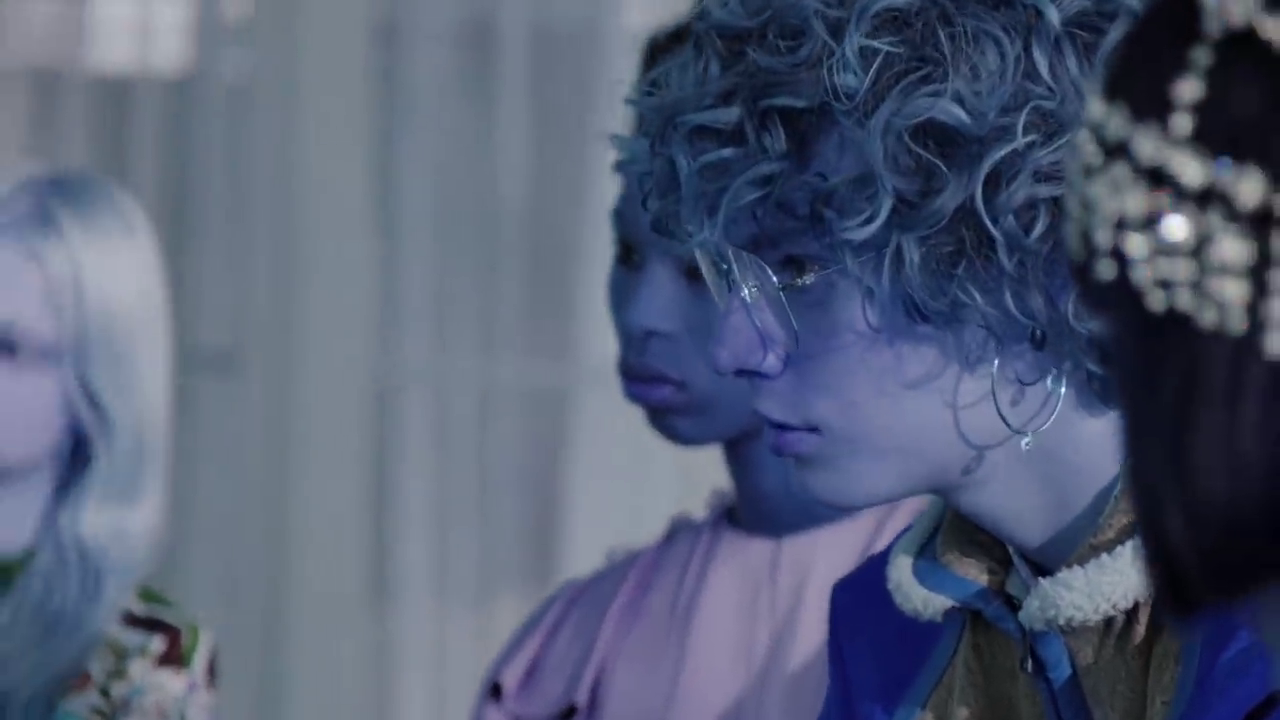

In [13]:
from google.colab.patches import cv2_imshow
cv2_imshow(keyframes[5])

In [15]:
type(keyframes[0])

numpy.ndarray

In [16]:
keyframes.shape

(25, 720, 1280, 3)